# Body area segmentation test notebook
This notebook is for testing various methods and parameters for body area segmentation. 

This notebook does not necessarily represent how the main project code functions and is used only as a testbed for optimising methods. The image data folder is not tracked to prevent an unnecessarily large git repo.

*Messy code below*

In [39]:
# add root directory to python path
import sys, os
if os.path.join(sys.path[0], '..') not in sys.path:
    sys.path.insert(1, os.path.join(sys.path[0], '..'))

# perform imports
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from sweeprecon.io.ImageData import ImageData

from multiprocessing import Pool, cpu_count
from scipy.ndimage import gaussian_filter, morphology, binary_fill_holes
from scipy.signal import medfilt2d, medfilt
from skimage import restoration, measure, segmentation, exposure, feature, filters
from skimage import morphology as morphology_skimage

In [4]:
# load image data and crop slices to reduce processing time
image_path = 'data/IMG_3D_cropped.nii.gz'

Image = ImageData(image_path)

Image.square_crop(crop_z=[100, 150])

rect not defined defaulting to full FOV


In [5]:
# Check shape
Image.img.shape

(384, 154, 52)

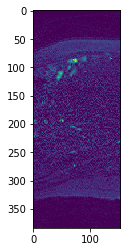

In [6]:
plt.imshow(Image.img[:,:,1])

In [7]:
# specified filters
def _filter_median(img, kernel_size=5):
    """
    Median filter
    :param imgs: slice to filter [2D]
    :param kernel_size: size of median kernel
    :return:
    """
    return medfilt2d(img, [kernel_size, kernel_size])  # median filter more robust to bands in balanced images

def _filter_denoise(img):
    """
    TV denoising
    :param imgs: slice to denoise [2D]
    :param weight: TV weight
    :return:
    """
    return restoration.denoise_tv_bregman(img, weight=0.003)

def _filter_inv_gauss(img, alpha=50, sigma=1.3):
    """
    TV denoising
    :param imgs: image to denoise [2D]
    :param weight: TV weight
    :return:
    """
    return segmentation.inverse_gaussian_gradient(img, alpha=alpha, sigma=sigma)

def _filter_adaptive_hist_eq(img, clip_limit=0.02):
    """
    adaptive histogram equalisation
    :param imgs: image to equalise [2D]
    :return:
    """
    return exposure.equalize_adapthist(img.astype('uint16'), clip_limit=clip_limit)

def _filter_canny(img):
    """
    canny edge detection
    :param imgs: image to filter [2D]
    :return:
    """
    return feature.canny(img, sigma=5.0, low_threshold=0.6, high_threshold=0.9, use_quantiles=True)

def _segment_flood(img):
    """
    adaptive histogram equalisation
    :param imgs: slice to equalise [2D]
    :return:
    """
    img = filters.gaussian(img.astype(int))
    seg_ant = segmentation.flood(img, (1, 2), selem=morphology_skimage.selem.disk(1))
    seg_post = segmentation.flood(img, (img.shape[0] - 1, 0), selem=morphology_skimage.selem.disk(1))
    return seg_ant + seg_post

def _segment_cv(img, init_level_set, iterations=100):
    """
    refines initial segmentation contours using chan vese segmentation model
    :param img: slice to segment:
    :param init_level_set: initial level set - starting segmentation
    :param iterations: number of refinement iterations
    :return:
    """
    return segmentation.morphological_chan_vese(img,
                                                iterations,
                                                init_level_set=init_level_set,
                                                smoothing=9,
                                                lambda1=0.5,
                                                lambda2=3.0
                                                )

def _segment_gac(img, init_level_set, iterations=300):
    """
    refines initial segmentation contours using geodesic active contours
    :param imgs: list of 2 images [2D] imgs[0] = slice to segment: imgs[1] = initial level set
    :param iterations: number of refinement iterations
    :return:
    """
    return segmentation.morphological_geodesic_active_contour(img,
                                                              iterations,
                                                              init_level_set=init_level_set,
                                                              smoothing=8,
                                                              balloon=1.2
                                                              )

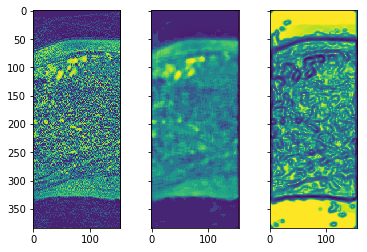

In [8]:
# pre-filter data
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')

filtered_image = copy.deepcopy(Image.img)

for zz in range(0, Image.img.shape[2]):
        filtered_image[:,:,zz] = _filter_adaptive_hist_eq(filtered_image[:,:,zz], clip_limit=0.1)

img_contrast_enhanced = copy.deepcopy(filtered_image)
ax[0].imshow(filtered_image[:,:,1])       

for zz in range(0, Image.img.shape[2]):
        filtered_image[:,:,zz] = _filter_median(filtered_image[:,:,zz], kernel_size=9)
        
ax[1].imshow(filtered_image[:,:,1])

for zz in range(0, Image.img.shape[2]):
        filtered_image[:,:,zz] = _filter_inv_gauss(filtered_image[:,:,zz], alpha=120, sigma=1.6)
        
ax[2].imshow(filtered_image[:,:,1])


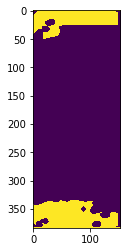

In [9]:
# initalise contours
init_level_set = np.zeros(filtered_image.shape)

thresh = np.mean(filtered_image[[0, filtered_image.shape[0] - 1], :, :])
img_thresh = filtered_image >= thresh
img_thresh[[0, filtered_image.shape[0] - 1], :, :] = True  # always include most anterior/posterior rows in mask

labels = measure.label(img_thresh, background=0, connectivity=1)

init_level_set[(labels == labels[0, 0, 0]) | (labels == labels[filtered_image.shape[0] - 1, 0, 0])] = True

plt.imshow(init_level_set[:,:,1])

In [10]:
# segment
segmented_image = copy.deepcopy(filtered_image)

for zz in range(0, Image.img.shape[2]):
    segmented_image[:,:,zz] = _segment_gac(filtered_image[:,:,zz], init_level_set[:,:,zz], iterations=300)
    
print('--- Segmentation finished ---')

--- Segmentation finished ---


In [11]:
# crop + invert to create body mask
cropval = int(0.1 * segmented_image.shape[1])
segmented_image = (segmented_image == 0) * 1

rect = np.array([[0 + cropval, 0], [segmented_image.shape[1]-1-cropval, segmented_image.shape[0]]], dtype=int)

dx = rect[1, 0] - rect[0, 0]
dy = rect[1, 1] - rect[0, 1]

img_crop = img_contrast_enhanced[rect[0, 1]:rect[0, 1] + dy, rect[0, 0]:rect[0, 0] + dx, :]
refined_mask = segmented_image[rect[0, 1]:rect[0, 1] + dy, rect[0, 0]:rect[0, 0] + dx, :]

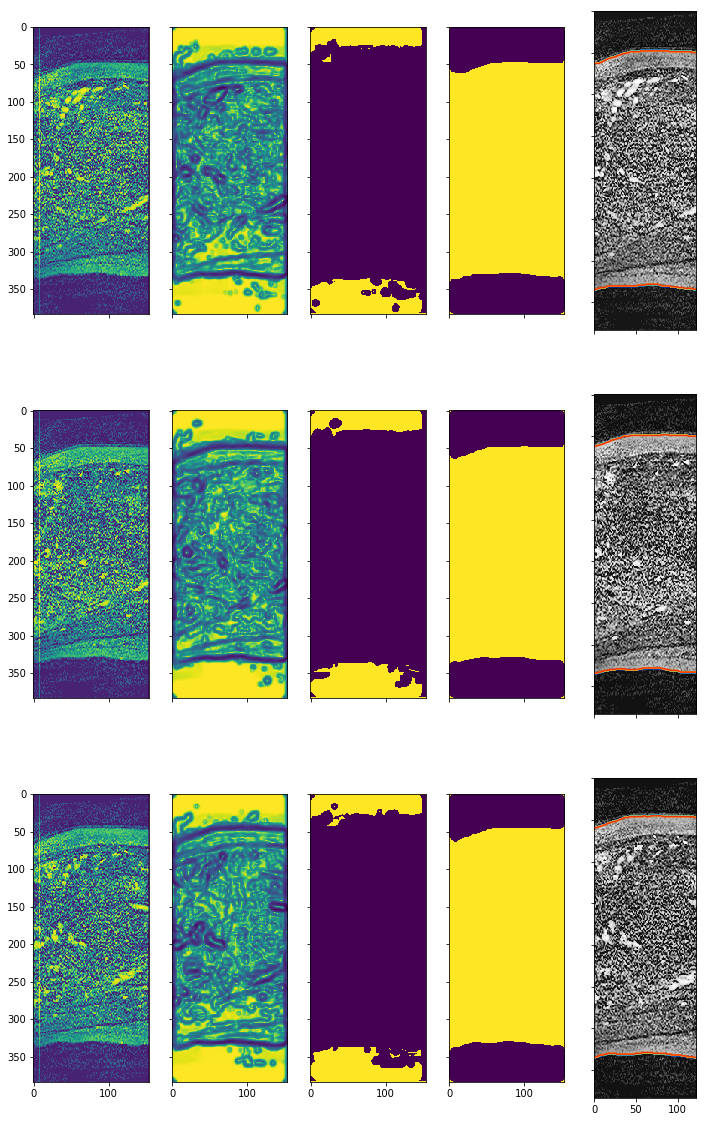

In [15]:
# check results
ntests = 3
fig, ax = plt.subplots(ntests, 5, sharex='col', sharey='row', figsize=(12, 20))

#slices = np.linspace(0,filtered_image.shape[2]-1, ntests, dtype=int)
slices = np.random.randint(0,filtered_image.shape[2]-1, size=ntests)

for i in range(0, ntests):
    zq = slices[i]
    ax[i, 0].imshow(img_contrast_enhanced[:,:,zq])
    ax[i, 1].imshow(filtered_image[:,:,zq])
    ax[i, 2].imshow(init_level_set[:,:,zq])
    ax[i, 3].imshow(segmented_image[:,:,zq])
    
    # overlay
    ax[i, 4].imshow(img_crop[:,:,zq], cmap='gray')
    ax[i, 4].contour(refined_mask[:,:,zq], cmap='jet')
    

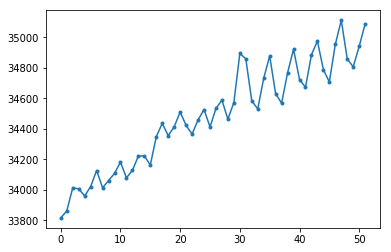

In [16]:
# sum pixels
resp_raw = np.squeeze(np.sum(refined_mask, axis=(0, 1)))
plt.plot(resp_raw,'.-')

In [227]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, filt_r_cm=5, iter=1):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    
    fs = Image.nii.header["pixdim"][3]
    #r = ceil(filt_r_cm / (1/fs))
    kern=640
    r = min(len(x)-1,kern)

    n = len(x)
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [210]:
dz = Image.nii.header["pixdim"][3]
dz
r = min(ceil((2 * 10) / dz), 
r

64

In [214]:
fs = Image.get_fs()
r = ceil(10 / (1/fs))
r

10

51
51


(-238.58083788483705, 299.43444617907005)

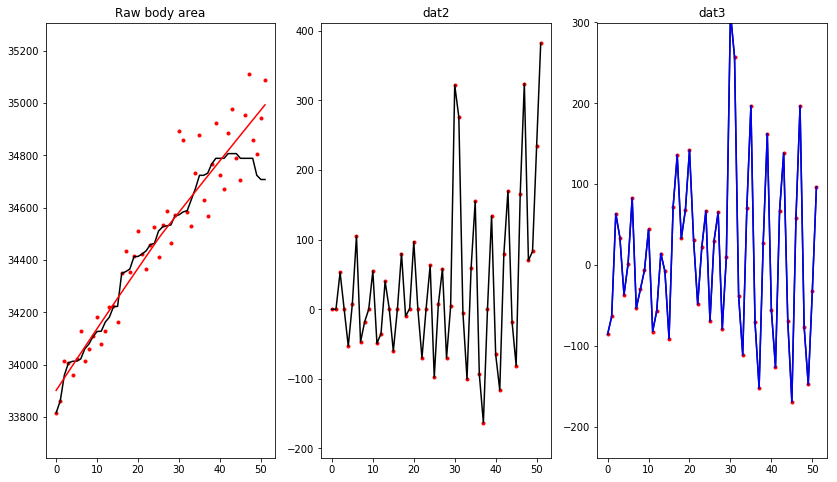

In [228]:
#using clever plot tool
import sweeprecon.utilities.PlotFigures as pltfigs
import matplotlib.gridspec as gridspec

import importlib
importlib.reload(pltfigs)

y_mean1 = medfilt(resp_raw, kernel_size=19)

y_mean2 = lowess_ag(np.arange(0, resp_raw.shape[0]), resp_raw, iter=50)
y_mean3 = lowess_ag(np.arange(0, resp_raw.shape[0]), resp_raw, iter=5)

sts = np.ones(resp.shape)

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 3, figure=fig)

dat1 = resp_raw
dat2 = resp_raw - y_mean1
dat3 = resp_raw - y_mean2
dat4 = resp_raw - y_mean3

ax1 = plt.subplot(gs[0])
ax1.set_title('Raw body area')
ax1.scatter(range(0, dat1.shape[0]), dat1, marker=".", c='r')

ax1.plot(range(0, y_mean1.shape[0]), y_mean1, c='k')
ax1.plot(range(0, y_mean2.shape[0]), y_mean2, c='r')

qq1 = pltfigs.get_expand_ylim(dat1, 0.05, 0.95, edge_factor=1.0)
ax1.set_ylim(qq1[0], qq1[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('dat2')
ax2.scatter(range(0, dat2.shape[0]), dat2, marker=".", c='r')
ax2.plot(range(0, dat2.shape[0]), dat2, c='k')
qq2 = pltfigs.get_expand_ylim(dat2, 0.05, 0.95, edge_factor=1.0)
ax2.set_ylim(qq2[0], qq2[1])

ax2 = plt.subplot(gs[2])
ax2.set_title('dat3')
ax2.scatter(range(0, dat3.shape[0]), dat3, marker=".", c='r')
ax2.plot(range(0, dat3.shape[0]), dat3, c='k')
ax2.plot(range(0, dat4.shape[0]), dat4, c='b')

qq2 = pltfigs.get_expand_ylim(dat3, 0.05, 0.95, edge_factor=1.0)
ax2.set_ylim(qq2[0], qq2[1])

In [53]:
qq1 = get_expand_ylim(resp_raw, 0.1, 0.9, edge_factor=0.1)
print(qq1)

ax1.set_ylim(qq1[0], qq1[1])

[30613.319999999996, 38412.22]


(30613.319999999996, 38412.22)